### DATA PREPARATION

In [59]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Layer, Bidirectional
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [61]:
df = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/442100110323_15min_stationary.csv')
df['READ_DATE'] = pd.to_datetime(df['READ_DATE'])
df.set_index('READ_DATE', inplace=True)
df

,KWH_EXP_diff
READ_DATE,
2019-01-01 00:00:00,0.000353
2019-01-01 00:15:00,0.009907
2019-01-01 00:30:00,0.156262
2019-01-01 00:45:00,-0.068215
2019-01-01 01:00:00,-0.043631
...,...
2024-05-31 22:45:00,0.000000
2024-05-31 23:00:00,0.000000
2024-05-31 23:15:00,-0.358020


In [62]:
# split data train dan test. 3 tahun pertama untuk train, 2 tahun terakhir untuk test
train = df.loc['2019-01-01':'2022-12-31']
test = df.loc['2023-01-01':]

In [66]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [67]:
# jika datanya diambil setiap 15 menit, maka time_steps = 96 berarti 24 jam

time_steps = 96
# reshape ke bentuk 3D array
X_train, y_train = create_dataset(train, train['KWH_EXP_diff'], time_steps)
X_test, y_test = create_dataset(test, test['KWH_EXP_diff'], time_steps)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(140160, 96, 1) (140160,)
(49536, 96, 1) (49536,)



<h4>SPLITTING DATA RATIO :

* Train data : tahun 2019-2022 akhir
* Test data : tahun 2023-ujung data
* Validation data : diambil 10% dari training data. Nantinya parameter `validation_split` di `model.fit` akan melakukan splitting data train

### TRAINING WITH BIDIRECTIONAL-LSTM

In [68]:
model = Sequential()
model.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(units=64, return_sequences=False)))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [69]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional)      │ (None, 96, 256)             │         133,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297,601 (1.14 MB)

 Trainable params: 297,601 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
#  callback
# early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
# learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# training
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.8962 - val_loss: 0.4990 - learning_rate: 0.0010
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.8443 - val_loss: 0.4991 - learning_rate: 0.0010
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.8384 - val_loss: 0.4861 - learning_rate: 0.0010
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.8286 - val_loss: 0.4830 - learning_rate: 0.0010
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.8243 - val_loss: 0.4894 - learning_rate: 0.0010
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.8205 - val_loss: 0.4754 - learning_rate: 9.0484e-04
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.8067 - val_loss: 0.4737 - learning_rate: 8.1873e-04
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.8002 - val_loss: 0.4751 - learning_rate: 7.4082e-04
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7955 - val_loss: 0.4738 - l

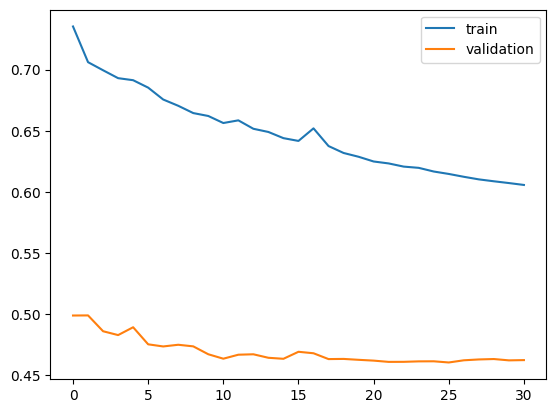

In [71]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [72]:
# predict

y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)


1548/1548 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step


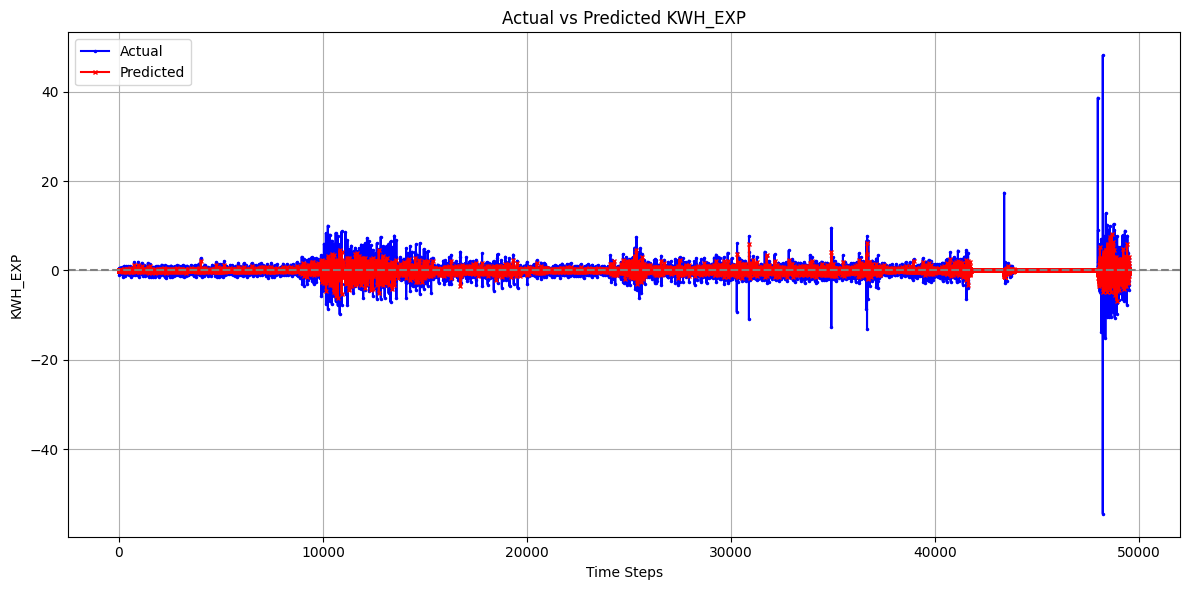

In [74]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Garis referensi
plt.title('Actual vs Predicted KWH_EXP')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [75]:
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.42979002182587245
MAE: 0.2155157630390203
R2: 0.14192761507413054
MAPE: 11556159391191.31


### TRAINING WITH LSTM + ATTENTION LAYER

In [76]:
# Define Attention Layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        attention_weights = tf.nn.softmax(tf.matmul(inputs, inputs, transpose_b=True), axis=-1)
        context_vector = tf.matmul(attention_weights, inputs)
        return context_vector

# Model definition with Attention
input_shape = (X_train.shape[1], X_train.shape[2])
inputs = Input(shape=input_shape)
x = LSTM(units=128, return_sequences=True)(inputs)
x = AttentionLayer()(x)
x = LSTM(units=64, return_sequences=False)(x)
outputs = Dense(units=1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 96, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 96, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_4 (AttentionLayer)   │ (None, 96, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.9976 - val_loss: 0.5667 - learning_rate: 0.0010
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.9939 - val_loss: 0.5612 - learning_rate: 0.0010
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.9852 - val_loss: 0.5543 - learning_rate: 0.0010
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.9638 - val_loss: 0.5415 - learning_rate: 0.0010
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.9469 - val_loss: 0.5336 - learning_rate: 0.0010
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.9311 - val_loss: 0.5336 - learning_rate: 9.0484e-04
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9117 - val_loss: 0.5289 - learning_rate: 8.1873e-04
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.9014 - val_loss: 0.5259 - learning_rate: 7.4082e-04
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.8934 - val_loss: 0.5247 - le

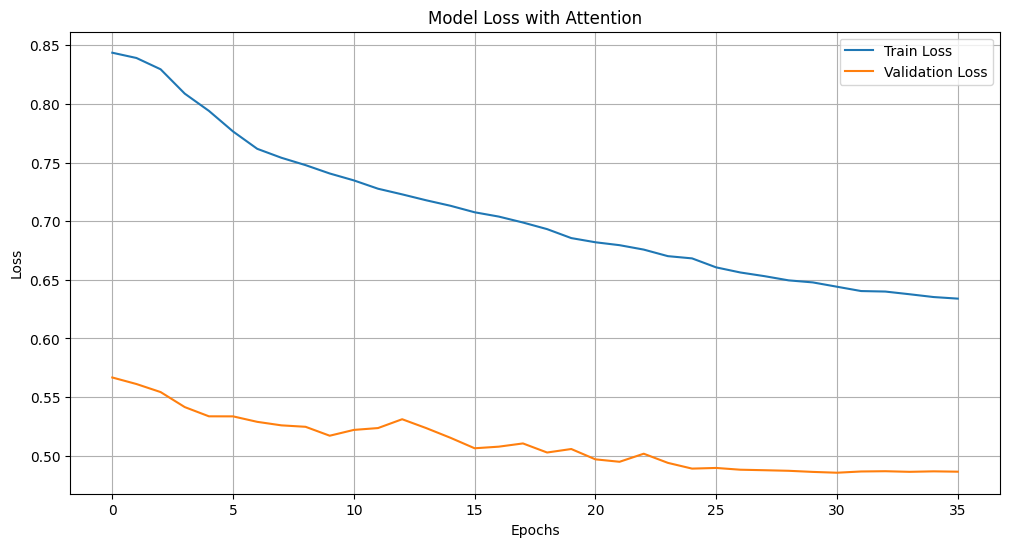

1548/1548 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


In [77]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

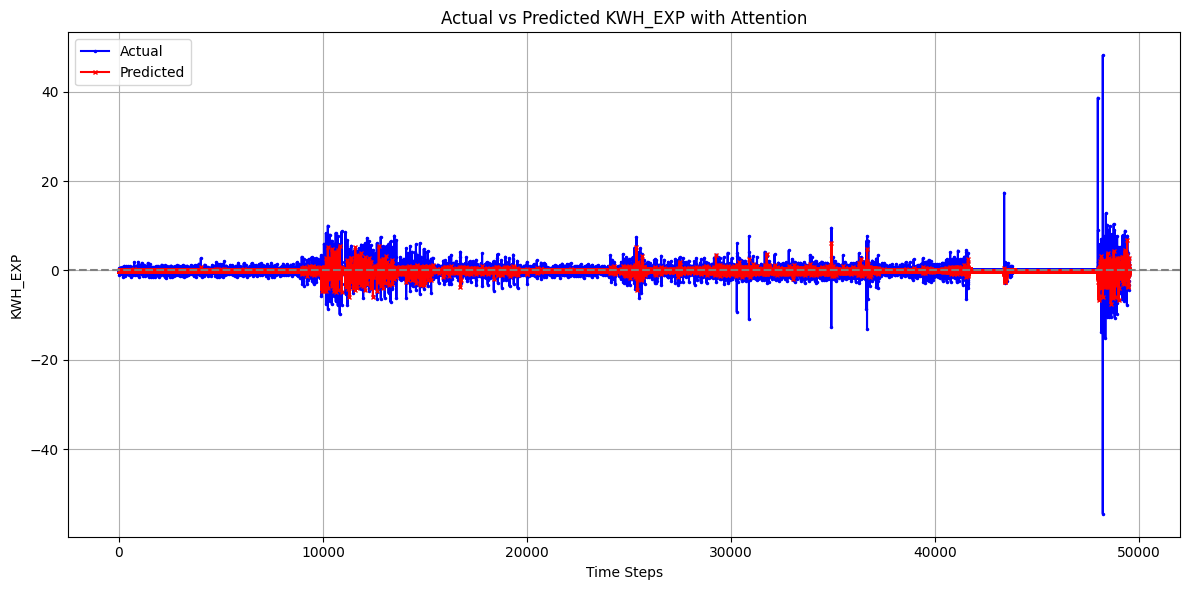

In [78]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.title('Actual vs Predicted KWH_EXP with Attention')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [79]:
# Metrics
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.45372776266478976
MAE: 0.22606938249163103
R²: 0.0941361045031639
MAPE: 19350110959583.516


### TRAINING WITH BIDIRECTIONAL-LSTM + ATTENTION LAYER

In [80]:
# Define Attention Layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, inputs):
        attention_weights = tf.nn.softmax(tf.matmul(inputs, inputs, transpose_b=True), axis=-1)
        context_vector = tf.matmul(attention_weights, inputs)
        return context_vector

# Model definition with Attention
input_shape = (X_train.shape[1], X_train.shape[2])
inputs = Input(shape=input_shape)
x = Bidirectional(LSTM(units=128, return_sequences=True))(inputs)
x = AttentionLayer()(x)
x = Bidirectional(LSTM(units=64, return_sequences=False))(x)
outputs = Dense(units=1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 96, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 96, 256)             │         133,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_5 (AttentionLayer)   │ (None, 96, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297,601 (1.14 MB)

 Trainable params: 297,601 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.9433 - val_loss: 0.5068 - learning_rate: 0.0010
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.8720 - val_loss: 0.4935 - learning_rate: 0.0010
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.8395 - val_loss: 0.4756 - learning_rate: 0.0010
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.8236 - val_loss: 0.4857 - learning_rate: 0.0010
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.8111 - val_loss: 0.4733 - learning_rate: 0.0010
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7990 - val_loss: 0.4658 - learning_rate: 9.0484e-04
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7893 - val_loss: 0.4647 - learning_rate: 8.1873e-04
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.7841 - val_loss: 0.4578 - learning_rate: 7.4082e-04
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7833 - val_loss: 0.4648 - l

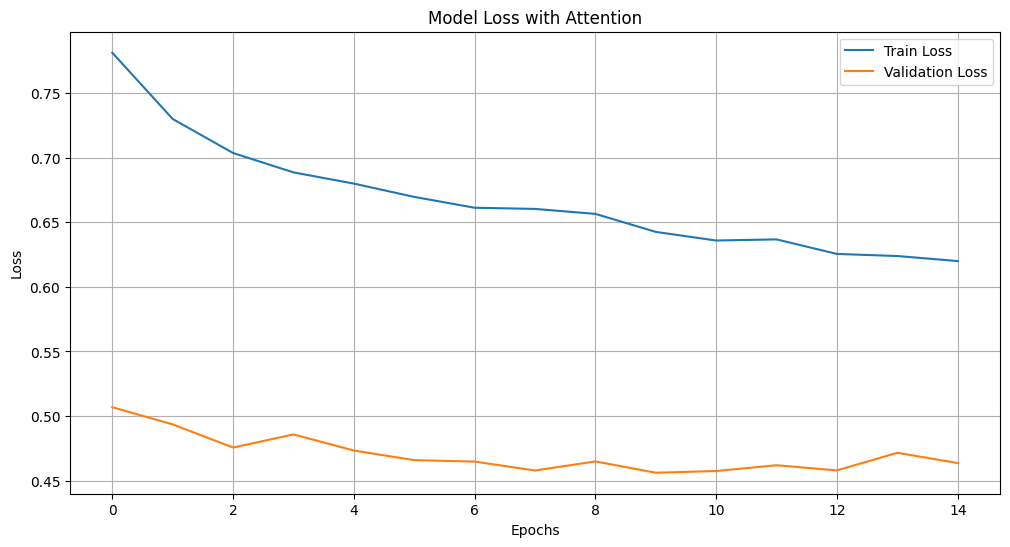

1548/1548 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step


In [81]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

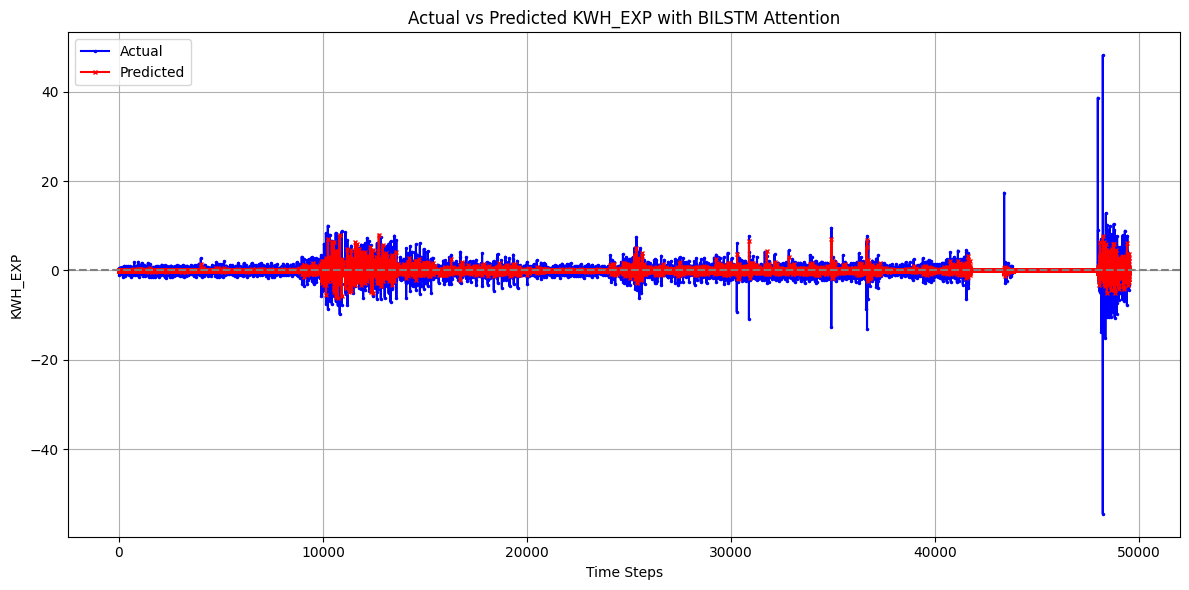

In [82]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.title('Actual vs Predicted KWH_EXP with BILSTM Attention')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [83]:
# Metrics
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.43375224691694453
MAE: 0.21806291588221824
R²: 0.13401706396578783
MAPE: 16600650021028.102


### TRAINING WITH LSTM

In [84]:
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=1))

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

# Training the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=512,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stopping, lr_scheduler]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 96, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 96, 256)             │         133,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_5 (AttentionLayer)   │ (None, 96, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297,601 (1.14 MB)

 Trainable params: 297,601 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.7528 - val_loss: 0.4637 - learning_rate: 0.0010
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7572 - val_loss: 0.4629 - learning_rate: 0.0010
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7595 - val_loss: 0.4582 - learning_rate: 0.0010
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7474 - val_loss: 0.4523 - learning_rate: 0.0010
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7418 - val_loss: 0.4788 - learning_rate: 0.0010
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7431 - val_loss: 0.4670 - learning_rate: 9.0484e-04
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7410 - val_loss: 0.4669 - learning_rate: 8.1873e-04
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7388 - val_loss: 0.4731 - learning_rate: 7.4082e-04
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7279 - val_loss: 0.4715 - l

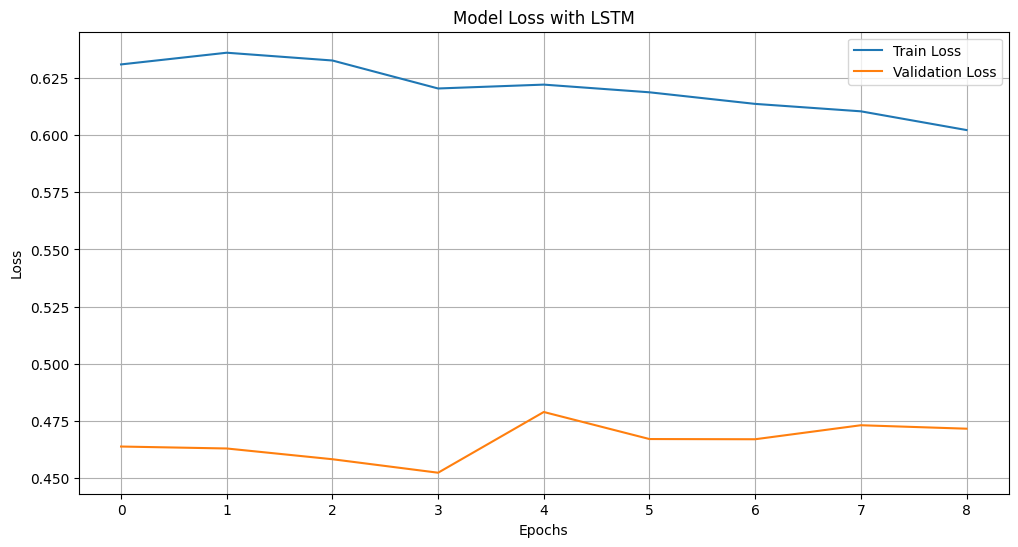

1548/1548 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step


In [85]:
# Plotting the loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Predictions
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

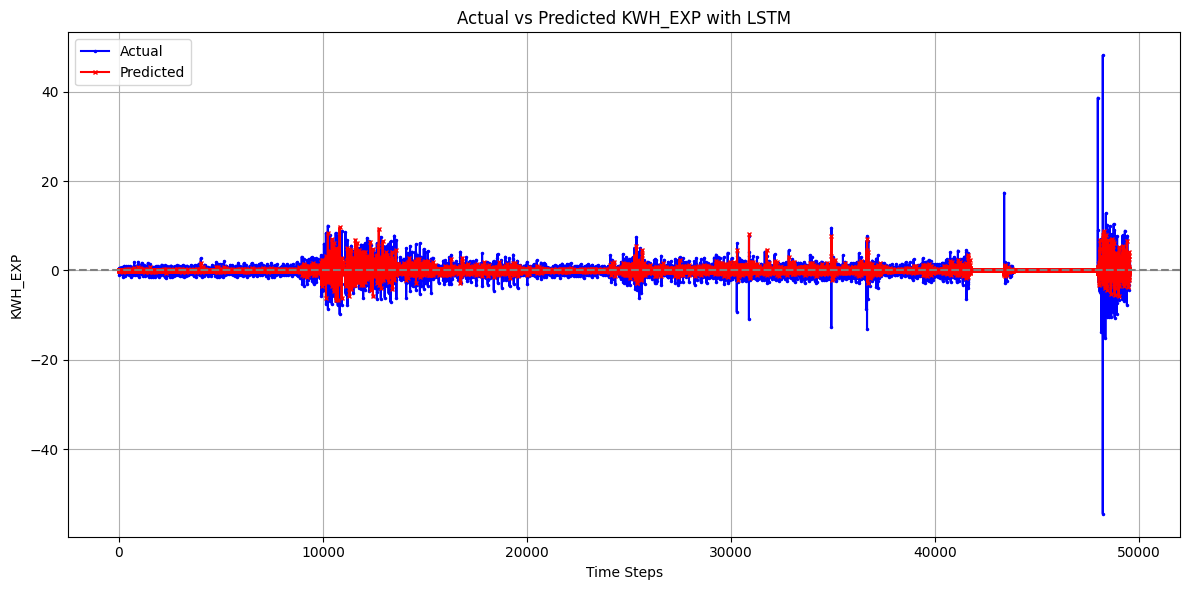

In [86]:
# Actual vs Predicted plot
plt.figure(figsize=(12, 6))
plt.plot(y_test, marker='.', label='Actual', color='blue', markersize=3)
plt.plot(y_pred, marker='x', label='Predicted', color='red', markersize=3)
plt.axhline(0, color='gray', linestyle='--')  # Reference line
plt.title('Actual vs Predicted KWH_EXP with LSTM')
plt.xlabel('Time Steps')
plt.ylabel('KWH_EXP')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [87]:
# Metrics
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R²:', r2_score(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MSE: 0.44722725605114366
MAE: 0.22803963963246432
R²: 0.10711431462889265
MAPE: 28447452777634.336
